# 采用EM算法评估多维认知诊断模型DINA的参数

## 1. 模型概述

DINA认知诊断模型通过研究学生、试题、知识点三者之间的关系，依据学生的答题得分信息，以及试题与知识点的关联信息，评估学生**是否**掌握各个知识点。DINA模型涉及三个核心矩阵：

1. 学生 - 试题 矩阵 X (学生实际答题信息)，矩阵格式如下：

<table style="width:600px">
    <tr><th>$X$</th><th>试题1</th><th>试题2</th><th>试题3</th><th>……</th><th>试题$J$</th></tr>
    <tr><td>学生1</td><td>0</td><td>1</td><td>0</td><td>……</td><td>1</td></tr>
    <tr><td>学生2</td><td>1</td><td>0</td><td>0</td><td>……</td><td>1</td></tr>
    <tr><td>学生3</td><td>0</td><td>1</td><td>1</td><td>……</td><td>0</td></tr>
    <tr><td>……</td><td>…</td><td>…</td><td>…</td><td>……</td><td>…</td></tr>
    <tr><td>学生$I$</td><td>1</td><td>1</td><td>0</td><td>……</td><td>1</td></tr>
</table>

> 假设共有$I$个学生,$J$个试题，其中$X_{ij}$代表第$i$个学生是否答对了第$j$题。如$X_{3,2} = 1$ 代表第3个学生回答正确了第2题。

2. 试题 - 知识点 矩阵 Q (记录回答对试题需要掌握哪些知识点)， 矩阵格式如下：

<table style="width:600px">
    <tr><th>$Q$</th><th>试题1</th><th>试题2</th><th>试题3</th><th>……</th><th>试题$J$</th></tr>
    <tr><td>知识点1</td><td>1</td><td>1</td><td>0</td><td>……</td><td>0</td></tr>
    <tr><td>知识点2</td><td>1</td><td>0</td><td>1</td><td>……</td><td>1</td></tr>
    <tr><td>知识点3</td><td>0</td><td>1</td><td>1</td><td>……</td><td>0</td></tr>
    <tr><td>……</td><td>…</td><td>…</td><td>…</td><td>……</td><td>…</td></tr>
    <tr><td>知识点$K$</td><td>0</td><td>0</td><td>1</td><td>……</td><td>1</td></tr>
</table>

> 假设共有 $K$ 个知识点，上述矩阵中每一列，代表答对对应试题所需要的知识点。如 $Q_{:,1}$ 代表答对第一题所需要的知识点集合。

3. 学生 - 知识点 矩阵 A (待求解的矩阵，记录学生掌握了哪些知识点)， 矩阵的格式如下：

<table style="width:600px">
    <tr><th>$A$</th><th>学生1</th><th>学生2</th><th>学生3</th><th>……</th><th>学生$I$</th></tr>
    <tr><td>知识点1</td><td>1</td><td>1</td><td>0</td><td>……</td><td>0</td></tr>
    <tr><td>知识点2</td><td>1</td><td>0</td><td>1</td><td>……</td><td>1</td></tr>
    <tr><td>知识点3</td><td>0</td><td>1</td><td>1</td><td>……</td><td>0</td></tr>
    <tr><td>……</td><td>…</td><td>…</td><td>…</td><td>……</td><td>…</td></tr>
    <tr><td>知识点$K$</td><td>0</td><td>0</td><td>1</td><td>……</td><td>1</td></tr>
</table>

> 上述矩阵中每一列代表每个学生掌握的知识点。如 $A_{:,1}$ 代表答对第一学生掌握的知识点集合，$A_{2,1} = 1$ 代表第1个学生掌握了第2个知识点。

理想情况下，学生只要掌握了试题所需的知识点，既可以答对试题，因此：

$$\eta_{i,j} = \prod_{k=1}^K{a_{k,i}^{q_{k,j}}} \tag{1}$$

上式中$\eta_{i,j}$表示理想情况下学生 $i$ 能否回答对试题 $j$ ，当 $q_{k,j} = 0$ 时，因为任何数的0次方都是1，因此对连乘没有影响，只有 $q_{k,j} = 1$ 才会起作用。若学生有试题中的任何一个知识点未掌握，因为 0 的1次方等于0，会造成连乘为0，从而得出 $\eta_{i,j}= 0$ 即学生无法回答正确该题。

In [2]:
# 模拟测试

import numpy as np

# 构建学生知识点矩阵,共有4个学生，3个知识点
A = np.array([[0,1,1,0],[1,0,1,0],[1,1,0,1]])
# 构建试题知识点矩阵，共有2道试题，3个知识点
Q = np.array([[1,0],[1,1],[0,1]])

print("学生知识点矩阵为：\n",A)
print("试题知识点矩阵为：\n",Q)
print("第一个学生掌握的知识点集合：", A[:,0])
print("第一道试题需要的知识点集合：", Q[:,0])
print("第二道试题需要的知识点集合：", Q[:,1])

学生知识点矩阵为：
 [[0 1 1 0]
 [1 0 1 0]
 [1 1 0 1]]
试题知识点矩阵为：
 [[1 0]
 [1 1]
 [0 1]]
第一个学生掌握的知识点集合： [0 1 1]
第一道试题需要的知识点集合： [1 1 0]
第二道试题需要的知识点集合： [0 1 1]


可以看出，第一个学生掌握的知识点不足以回答对第一道题，但是可以回答对第二道题。

依据公式1，根据学生掌握的知识点情况 和 试题需要的知识点情况，计算学生能否答对对应的试题。

In [3]:
# 计算理想情况下学生的答题情况
def compute_eta(Q,A):
    
    # 获取学生数量、试题数量和知识点数量
    num_students = A.shape[1]
    num_questions = Q.shape[1]
    num_knowleges = A.shape[0]

    # 初始化学生答题矩阵，默认为1
    eta = np.ones(shape=(num_students, num_questions))

    # 通过遍历计算学生的答题矩阵
    for i in range(num_students):
        for j in range(num_questions):
            # 依据公式(1) 进行连乘计算
            for k in range(num_knowleges):
                eta[i,j] *= A[k,i]**Q[k,j]
    return eta

eta = compute_eta(Q,A)
print("学生的答题情况为：\n", eta)
print("第1个学生的答题情况为：", eta[0,:])

学生的答题情况为：
 [[0. 1.]
 [0. 0.]
 [1. 0.]
 [0. 0.]]
第1个学生的答题情况为： [0. 1.]


与预估的一样，学生第一道题答题错误，第二道题答题正确。但上述计算是基于理想情况下的，即学生掌握了试题所学的知识点就一定能答对，学生缺少试题中的任何一个知识点就会回答错误。然而真实的情况下，学生及时掌握了所有知识点也存在失误的情况，还有学生未掌握对应的知识点也存在猜对的情况。因此DINA为每个试题引入了两个参数：失误率 $s_j$ 和 猜对率 $g_j$。

则学生真是情况下能答对试题的概率，可用下面的式子表示：

$$P_j(a_u^{<i>}) = P(X_{i,j} = 1 | a_u^{<i>}) = g_j^{(1-\eta_{ij})}(1 - s_j)^{\eta_{ij}}  \tag{2}$$

$P(X_{i,j} = 1 | a_u^{<i>})$ 表示 第 $i$ 个学生掌握的知识点集合为 $a_u$ 的情况下,学生回答对试题 $j$ 的概率。 

当 $\eta_{ij} = 1$ 时，学生回答对试题的概率等于 1 减去 试题的平均失误率 $s_j$；当 $\eta_{ij} = 0$ 时，学生回答对的试题等于试题的平均猜对率 $g_j$。


In [5]:
s = np.zeros(shape=(2))  + 0.25
g = np.zeros(shape=(2))  + 0.25

# 加入猜对率和失误率后，计算学生每道试题答对的概率
def compute_propa(eta, s, g):
    propa = np.zeros(shape=eta.shape)

    for i in range(eta.shape[0]):
        for j in range(eta.shape[1]):
            propa[i,j] = (g[j]**(1 - eta[i,j]))*((1-s[j])**eta[i,j])
    return propa

propa = compute_propa(eta, s, g)
print("学生答对各道试题的概率为: \n", propa)
print("第一个学生理想情况下答对试题的概率为:", eta[0,:])
print("第一个学生现实情况下答对试题的概率为:", propa[0,:])

学生答对各道试题的概率为: 
 [[0.25 0.75]
 [0.25 0.25]
 [0.75 0.25]
 [0.25 0.25]]
第一个学生理想情况下答对试题的概率为: [0. 1.]
第一个学生现实情况下答对试题的概率为: [0.25 0.75]


可以看出第一个学生答对第一题的概率为0.25，因为在不全部掌握试题知识点的情况下，猜对的概率为0.25, 第二题答对的概率为0.75，因为试题对应知识点全掌握的情况下，仍有0.25的失误率。

## 2. EM算法参数评估

DINA模型待求解的参数为学生的知识点掌握矩阵以及试题的失误率和猜对率。 其中学生的知识点掌握情况$\alpha_k^{<i>}$是无法观测的，相当于隐变量,试题的猜对率$g_j$和失误率$s_j$相当于模型参数，统一用 $\theta$ 表示。因此可以使用EM算法进行评估。

### 2.1 隐变量空间

对应一个知识点，学生会有两种情况，掌握或未掌握。如果有$K$个知识点，则知识点掌握的组合情况为：$U=2^K$个。
令 $\gamma_{i,u}$表示第$i$个学生的掌握的知识点是否对应第$u$个知识点组合，则：

$$ \gamma_{i,u}= \begin{cases} 1, & \text {学生掌握的知识点与该知识点组合相同} \\ 0, & \text{学生掌握的知识点与该知识点组合不同} \end{cases} $$



In [7]:
from itertools import product

k = 3
# 获取所有的可能知识点组合,共 2^k 个
all_skills = np.array(list(product([0, 1], repeat=k)))
print("所有的知识点组合：\n",all_skills)

# 学生的知识点掌握情况(该学生掌握了后两个知识点)
student_skill = np.array([0,1,1])
for i in range(all_skills.shape[0]):
    if np.sum(student_skill == all_skills[i,:]) == k:
        print("该生掌握了第 %d 种知识组合" % (i+1))

所有的知识点组合：
 [[0 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 1]
 [1 0 0]
 [1 0 1]
 [1 1 0]
 [1 1 1]]
该生掌握了第 4 种知识组合


### 2.2 全概率似然

如果用$\pi_u$表示第$u$种知识组合的被学生掌握的概率。则学生掌握第 $u$ 个知识点组合，且学生答题情况如 $X_i$发生的概率为：

$$P(X_i,\alpha_u) = P(X_i|\alpha_u)p(\alpha_u) = \pi_uP(X_i|\alpha_u)  \tag{3}$$


其中：

$$P(X_i|\alpha_u) = \prod_{j=1}^J{p_j(\alpha_u)^{X_{ij}}(1 - p_j(\alpha_u))^{(1 - {X_{ij}})}}  \tag{4}$$

表示学生 $i$ 在掌握知识点组合 $u$ 的情况下，答题情况为 $ X_i$ 发生的概率。

EM算法需要求样本的全概率似然，即观测数据和未观测数据同时发生的概率,因此对于学生答题结果和学生掌握知识点组合发生的概率：

$$
\begin{align}
P(X,\Gamma|\theta)  & = \prod_{u=1}^U{\prod_{i=1}^I{[P(X_i,\alpha_{u}|\theta)}]^{\gamma_{iu}}} \\
& = \prod_{u=1}^U{\prod_{i=1}^I{[P(X_i|\alpha_{u};\theta)P(\alpha_{u}|\theta)]^{\gamma_{iu}}}} \\
& = \prod_{u=1}^U{\prod_{i=1}^I{[\pi_uP(X_i|\alpha_{U};\theta)]^{\gamma_{iu}}}}
\end{align}
$$

则全概率似然为:

$$
\begin{align}
log(P(X,\Gamma|\theta))  & = \sum_{u=1}^U{\sum_{i=1}^I{\gamma_{iu}[log\pi_u + log(P(X_i|\alpha_{u};\theta))]}}  \tag{5}
\end{align}
$$

对全概率似然求期望,即 $Q$ 函数：

$$
\begin{align}
Q(\theta,\theta^{(t)}) = E(log(P(X,\Gamma|\theta)))  & = \sum_{u=1}^U{\sum_{i=1}^I{E(\gamma_{iu})[log\pi_u + log(P(X_i|\alpha_{u};\theta))]}}  \tag{6}
\end{align}
$$

求全概率似然的期望，需要求 $E(\gamma_{iu})$, 即第 i 个学生掌握第 $u$ 种知识点组合的期望,因为掌握时 $\gamma_{iu} = 1$,不掌握时为0，因此:

$$E(\gamma_{iu}) = P(\gamma_{iu} =1 | X_i;\theta)$$

即学生掌握第 $u$ 种知识点组合的条件概率(EM算法中的概率部分)，对上式进行化简：

$$
\begin{align}
E(\gamma_{iu})  & = P(\gamma_{iu} =1 | X_i;\theta) \\
& = \frac{P(\gamma_{iu} =1,X_i| \theta)}{\sum_{u=1}^U{P(\gamma_{iu} =1,X_i| \theta)}} \\
& = \frac{P(X_i|\gamma_{iu}=1;\theta)P(\gamma_{iu}=1|\theta)}{\sum_{u=1}^U{P(X_i|\gamma_{iu}=1;\theta)P(\gamma_{iu}=1|\theta)}} \\
& = \frac{\pi_u\prod_{j=1}^J{p_j(\alpha_u)^{X_{ij}}(1 - p_j(\alpha_u))^{(1 - {X_{ij}})}}}{\sum_{u=1}^U{\pi_u\prod_{j=1}^J{p_j(\alpha_u)^{X_{ij}}(1 - p_j(\alpha_u))^{(1 - {X_{ij}})}}}}  \tag{7}\\
\end{align}
$$

In [10]:
# 知识点数量
k = 3
U = 2**k

# 每个学生的答题情况，共4个学生两道试题
X = np.array([[0,1],[0,0],[0,1],[1,0]])

# 构建学生知识点矩阵,共有4个学生，3个知识点
A = np.array([[0,1,1,0],[1,0,1,0],[1,1,0,1]])
# 构建试题知识点矩阵，共有2道试题，3个知识点
Q = np.array([[1,0],[1,1],[0,1]])

# # 理想情况下学生是否能答对试题
# eta = compute_eta(Q,A)
# print("理想情况下学生的答题情况：\n",eta)

# 初始化每道题答题失误率
s = np.zeros(shape=(2))  + 0.25
# 初始化每道题答题猜对率
g = np.zeros(shape=(2))  + 0.25

# # 加入猜对率和失误率后，学生每道题答对的概率
# propa = compute_propa(eta, s, g)
# print("真实情况下学生的答题情况：\n",propa)

# 每种知识点组合被学生掌握的先验概率
pi = np.ones(shape=(U))/(U)
# 所有可能的知识点组合
all_skills = np.array(list(product([0, 1], repeat=k)))

print("试题所需要的知识点：\n",Q)
print("所有可能的知识组合：\n",all_skills.T)
# 学生-知识点组合 矩阵，记录每个学生掌握各个知识点组合的概率
gamma = np.ones(shape=(X.shape[0], U))

eta = compute_eta(Q,all_skills.T)
propa = compute_propa(eta, s, g)
print("理想情况下各个知识点组合的答题情况：\n",eta)
print("真实情况下各个知识点组合的答题情况：\n",propa)

for i in range(X.shape[0]):
    for u in range(U):
        gamma[i,u] *= pi[u]
        for j in range(Q.shape[1]):            
            gamma[i,u] *= (propa[u,j]**X[i,j])*((1-propa[u,j])**(1-X[i,j]))

print("𝐸(𝛾𝑖𝑢)=\n",gamma)

试题所需要的知识点：
 [[1 0]
 [1 1]
 [0 1]]
所有可能的知识组合：
 [[0 0 0 0 1 1 1 1]
 [0 0 1 1 0 0 1 1]
 [0 1 0 1 0 1 0 1]]
理想情况下各个知识点组合的答题情况：
 [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [1. 1.]]
真实情况下各个知识点组合的答题情况：
 [[0.25 0.25]
 [0.25 0.25]
 [0.25 0.25]
 [0.25 0.75]
 [0.25 0.25]
 [0.25 0.25]
 [0.75 0.25]
 [0.75 0.75]]
𝐸(𝛾𝑖𝑢)=
 [[0.0234375 0.0234375 0.0234375 0.0703125 0.0234375 0.0234375 0.0078125
  0.0234375]
 [0.0703125 0.0703125 0.0703125 0.0234375 0.0703125 0.0703125 0.0234375
  0.0078125]
 [0.0234375 0.0234375 0.0234375 0.0703125 0.0234375 0.0234375 0.0078125
  0.0234375]
 [0.0234375 0.0234375 0.0234375 0.0078125 0.0234375 0.0234375 0.0703125
  0.0234375]]


对$\gamma_{ru}$进行归一化，计算 $ P(\gamma_{iu} =1 | X_i;\theta)$ ,即学生掌握各种知识点组合的条件概率。

In [11]:
gamma_sum = np.sum(gamma, axis=1)
gamma = (gamma.T/gamma_sum).T
print("归一化后的gamma：\n",gamma)

归一化后的gamma：
 [[0.10714286 0.10714286 0.10714286 0.32142857 0.10714286 0.10714286
  0.03571429 0.10714286]
 [0.17307692 0.17307692 0.17307692 0.05769231 0.17307692 0.17307692
  0.05769231 0.01923077]
 [0.10714286 0.10714286 0.10714286 0.32142857 0.10714286 0.10714286
  0.03571429 0.10714286]
 [0.10714286 0.10714286 0.10714286 0.03571429 0.10714286 0.10714286
  0.32142857 0.10714286]]


可以看出第一个学生掌握第四种知识组合的概率最高为 32.14%，第二个学生掌握各种知识点组合的概率比较接近，第三个学生掌握第四种是指点的组合概率最高，第四个学生掌握第七种知识点组合的概率最高。

### 2.3 极大化 $Q$ 函数，计算下一步迭代的参数

对 $Q$ 函数进行求导，计算 $Q$ 函数取得极大值时，各个参数的值。首先将 $P(X_i|\alpha_u)$ 带入$Q$函数

$$
\begin{align}
Q(\theta,\theta^{(t)}) & = \sum_{u=1}^U{\sum_{i=1}^I{E(\gamma_{iu})[log\pi_u + log(P(X_i|\alpha_{u};\theta))]}} \\
& = \sum_{u=1}^U{\sum_{i=1}^I{E(\gamma_{iu})[log\pi_u + log\prod_{j=1}^J{p_j(\alpha_u)^{X_{ij}}(1 - p_j(\alpha_u))^{(1 - {X_{ij}})}}]}} \\
& = \sum_{u=1}^U{\sum_{i=1}^I{E(\gamma_{iu})[log\pi_u + \sum_{j=1}^J{[{X_{ij}}log(p_j(\alpha_u)) + {(1 - {X_{ij}})}log(1 - p_j(\alpha_u))]}]}}  \tag{8}\\
\end{align}
$$

$Q$ 函数对各题的猜对率 $g_j$进行求导。
 $$
\begin{align}
\frac{{\rm d}Q}{{\rm d} g_j} & = \sum_{u=1}^U{\sum_{i=1}^I{E(\gamma_{iu}){[\frac{X_{ij}}{p_j(\alpha_u)}\frac{{\rm d}p_j(\alpha_u)}{{\rm d} g_j} - \frac{(1 - {X_{ij}})}{1 - p_j(\alpha_u)}\frac{{\rm d}p_j(\alpha_u)}{{\rm d} g_j}]}}} \\
 & = \sum_{u=1}^U{\sum_{i=1}^I{E(\gamma_{iu})\frac{{\rm d}p_j(\alpha_u)}{{\rm d} g_j}{\frac{X_{ij} - p_j(\alpha_u)}{p_j(\alpha_u)(1 - p_j(\alpha_u))}}}} \\
 & = \sum_{u=1}^U{\frac{{\rm d}p_j(\alpha_u)}{{\rm d} g_j}{\frac{1}{p_j(\alpha_u)(1 - p_j(\alpha_u))}}}{\sum_{i=1}^I{[E(\gamma_{iu})X_{ij} - E(\gamma_{iu})p_j(\alpha_u))}]}  \tag{9}\\
\end{align}
$$

对于知识点组合 $\alpha_u$, 如果能覆盖试题需要的知识点 $q_j$，则试题答对的概率就等于1减去失误率，即 $p_j(\alpha_u) = 1 - s_j$。如果知识点组合 $\alpha_u$ 不能覆盖试题所需的知识点 $q_j$，则答对该题的概率就等于该题的猜对率，即 $p_j(\alpha_u) = g_j$。

1. 如果知识点组合 $\alpha_u$ 能覆盖试题所需的知识点 $q_j$，则 $\alpha_u\cdot{q_j^T} \geq q_j\cdot{q_j^T}$

2. 如果知识点组合 $\alpha_u$ 不能覆盖试题所需的知识点 $q_j$，则 $\alpha_u\cdot{q_j^T} < q_j\cdot{q_j^T}$

综上所述：

$$ p_j(\alpha_u)= \begin{cases} 1 - s_j, & \alpha_u\cdot{q_j^T} \geq q_j\cdot{q_j^T} \\ g_j, & \alpha_u\cdot{q_j^T} < q_j\cdot{q_j^T}  \tag{10}\end{cases} $$


In [12]:
q1 = Q[:,0]
a3 = all_skills[2,:]
a8 = all_skills[7,:]
print("试题1包含的知识点为: ", q1)
print("知识点组合3包含的知识点为: ", a3)
print("知识点组合8包含的知识点为: ", a8)

print("知识点组合3是否包含试题1所需的所有知识点？", np.dot(a3, q1.T) >= np.dot(q1, q1.T))
print("知识点组合8是否包含试题1所需的所有知识点？", np.dot(a8, q1.T) >= np.dot(q1, q1.T))

# 计算每个试题包含的知识点数量
kowns = np.sum(Q**2, axis=0)
# 计算每个知识点组合与试题共同包含的知识点数量
cross = np.dot(all_skills, Q)
print("知识点组合与试题共同包含的知识点数量: \n",cross)
cross[cross < kowns] = 0
cross[cross == kowns] = 1
print("知识点组合对应的答题结果: \n",cross)


试题1包含的知识点为:  [1 1 0]
知识点组合3包含的知识点为:  [0 1 0]
知识点组合8包含的知识点为:  [1 1 1]
知识点组合3是否包含试题1所需的所有知识点？ False
知识点组合8是否包含试题1所需的所有知识点？ True
知识点组合与试题共同包含的知识点数量: 
 [[0 0]
 [0 1]
 [1 1]
 [1 2]
 [1 0]
 [1 1]
 [2 1]
 [2 2]]
知识点组合对应的答题结果: 
 [[0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [1 0]
 [1 1]]



将式 (9) 中的知识点组合分成两部分，一部分能包含 $j$ 题所需的知识点，另一部分为不全部包含 $j$ 题所需的知识点。

 $$
\begin{align}
\frac{{\rm d}Q}{{\rm d} g_j} & = \sum_{\alpha_u\cdot{q_j^T} \geq q_j\cdot{q_j^T}}{\frac{{\rm d}p_j(\alpha_u)}{{\rm d} g_j}{\frac{1}{p_j(\alpha_u)(1 - p_j(\alpha_u))}}}{\sum_{i=1}^I{[E(\gamma_{iu})X_{ij} - E(\gamma_{iu})p_j(\alpha_u))}]}  \\
& + \sum_{\alpha_u\cdot{q_j^T} < q_j\cdot{q_j^T}}{\frac{{\rm d}p_j(\alpha_u)}{{\rm d} g_j}{\frac{1}{p_j(\alpha_u)(1 - p_j(\alpha_u))}}}{\sum_{i=1}^I{[E(\gamma_{iu})X_{ij} - E(\gamma_{iu})p_j(\alpha_u))}]}  \tag{11}\\
\end{align}
$$

将式 (10) 带入 式 (11) 可得：

 $$
\begin{align}
\frac{{\rm d}Q}{{\rm d} g_j} & = \sum_{\alpha_u\cdot{q_j^T} \geq q_j\cdot{q_j^T}}{\frac{{\rm d}(1-s_j)}{{\rm d} g_j}{\frac{1}{s_j(1 - s_j)}}}{\sum_{i=1}^I{[E(\gamma_{iu})X_{ij} - E(\gamma_{iu})(1-s_j))}]}  \\
& + \sum_{\alpha_u\cdot{q_j^T} < q_j\cdot{q_j^T}}{\frac{{\rm d}g_j}{{\rm d} g_j}{\frac{1}{g_j(1 - g_j)}}}{\sum_{i=1}^I{[E(\gamma_{iu})X_{ij} - E(\gamma_{iu})g_j)}]}  \\
& = \sum_{\alpha_u\cdot{q_j^T} < q_j\cdot{q_j^T}}{{\frac{1}{g_j(1 - g_j)}}}{\sum_{i=1}^I{[E(\gamma_{iu})X_{ij} - E(\gamma_{iu})g_j)}]} \tag{12} \\
\end{align}
$$

令 $\frac{{\rm d}Q}{{\rm d} g_j} = 0$ 可得：

$$\frac{{\rm d}Q}{{\rm d} g_j} = \sum_{\alpha_u\cdot{q_j^T} < q_j\cdot{q_j^T}}{{\frac{1}{g_j(1 - g_j)}}}{\sum_{i=1}^I{[E(\gamma_{iu})X_{ij} - E(\gamma_{iu})g_j)}]} = 0$$

因为 $g_j > 0$, 因此 $\frac{1}{g_j(1 - g_j)} \neq 0$，因此：
$$
\sum_{\alpha_u\cdot{q_j^T} < q_j\cdot{q_j^T}}{\sum_{i=1}^I{[E(\gamma_{iu})X_{ij} - E(\gamma_{iu})g_j)}]} = 0
$$

最终得出：

$$
g_j = \frac{\sum_{\alpha_u\cdot{q_j^T} < q_j\cdot{q_j^T}}{\sum_{i=1}^I{E(\gamma_{iu})X_{ij}}}}{\sum_{\alpha_u\cdot{q_j^T} < q_j\cdot{q_j^T}}{\sum_{i=1}^I{E(\gamma_{iu})}}} \tag{13}
$$

同理可以求出：

$$
s_j = \frac{\sum_{\alpha_u\cdot{q_j^T} \geq q_j\cdot{q_j^T}}{\sum_{i=1}^I{(E(\gamma_{iu}) - E(\gamma_{iu})X_{ij})}}}{\sum_{\alpha_u\cdot{q_j^T} \geq q_j\cdot{q_j^T}}{\sum_{i=1}^I{E(\gamma_{iu})}}} \tag{14}
$$

In [13]:
g_temp = np.zeros(g.shape)

for j in range(g.shape[0]):
    I = 0
    R = 0
    for u in range(all_skills.shape[0]):
        for i in range(X.shape[0]):
            if cross[u,j] == 0:
                I += gamma[i,u]
                R += gamma[i,u]*X[i,j]
    g_temp[j] = R/I

print("更新前各题的猜对率为: ", g)
print("更新后各题的猜对率为: ", g_temp)

更新前各题的猜对率为:  [0.25 0.25]
更新后各题的猜对率为:  [0.17808219 0.39097744]


In [14]:
s_temp = np.zeros(s.shape)
for j in range(g.shape[0]):
    I = 0
    R = 0
    for u in range(all_skills.shape[0]):
        for i in range(X.shape[0]):
            if cross[u,j] == 1:
                I += gamma[i,u]
                R += gamma[i,u]*X[i,j]
    s_temp[j] = (I - R)/I

print("更新前各题的失误率为: ", s)
print("更新后各题的失误率为: ", s_temp)

更新前各题的失误率为:  [0.25 0.25]
更新后各题的失误率为:  [0.45833333 0.20408163]


## 3 对参数 $\pi_u$ 进行评估

de la Torre (2009)、宋丽红(2012 博士论文) 中模拟的数据，各个知识状态服从均匀分布，但实际情况应该更近似于高斯分布，即知识点完全没掌握和全部掌握的人较少，掌握部分知识点的人较多，因此不能简单的先验认为各个知识状态出行的概率相同，需要使用EM算法结合朗格拉日乘子法进行参数评估。

参数 $\pi_u$ 表示各种知识点组合被学生掌握的概率，因此其和值为1，即：

$$\sum_{u=1}^U{\pi_u} = 1$$

因此对 $\pi_u$ 求偏导，就属于带条件的求极值问题了。可以使用朗格拉日乘子法。此时 $Q$ 函数可以写成：

$$Q(\theta,\theta^{(t)})  = \sum_{u=1}^U{\sum_{i=1}^I{E(\gamma_{iu})[log\pi_u + log(P(X_i|\alpha_{u};\theta))]}} + \beta(\sum_{u=1}^U{\pi_u} - 1)$$

对 $\pi_u$ 求偏导,并让其等于0，可得：

$$\frac{{\rm d}Q}{{\rm d} \pi_u} = \sum_{i=1}^I{\frac{E(\gamma_{iu})}{\pi_u}} + \beta = 0  \tag{15}$$

上式中又引入了参数 $\beta$, 因此仍无法直接求解。我们对所有 $\pi_u$ 的偏导数进行求和：

$$\sum_{u=1}^U{\frac{{\rm d}Q}{{\rm d} \pi_u}} = \sum_{u=1}^U{\sum_{i=1}^I{\frac{E(\gamma_{iu})}{\pi_u}}} + \sum_{u=1}^U{\beta} = 0$$

对上式进行化简：

$$\sum_{u=1}^U{\sum_{i=1}^I{E(\gamma_{iu})}} + \sum_{u=1}^U{\beta\pi_u} = 0$$


又因为：$\sum_{u=1}^U{\pi_u} = 1$，因此：

$$\sum_{u=1}^U{\sum_{i=1}^I{E(\gamma_{iu})}} + \beta = 0 \implies \beta = -\sum_{u=1}^U{\sum_{i=1}^I{E(\gamma_{iu})}}$$

又因为$E(\gamma_{iu}) = P(\gamma_{iu} =1 | X_i;\theta)$ 表示第$i$个学生掌握第$u$种知识组合的概率，因此 $\sum_{u=1}^U{E(\gamma_{iu})} = 1$，因此：

$$\beta = -\sum_{u=1}^U{\sum_{i=1}^I{E(\gamma_{iu})}} = -\sum_{i=1}^I{\sum_{u=1}^U{E(\gamma_{iu})}} = \sum_{i=1}^I{1} = -I$$

其中 $I$ 为学生的数量，将 $\beta$ 带入式 (15) 可得：

$$\pi_u = \frac{\sum_{i=1}^I{E(\gamma_{iu})}}{I}$$

直观的理解是 $\pi_u$ 等于掌握第 $u$ 种知识点组合的人数除以总人数。

In [15]:
temp_pi = np.zeros(pi.shape)

for u in range(gamma.shape[1]):
    for i in range(gamma.shape[0]):
        temp_pi[u] += gamma[i,u]
    temp_pi[u] /= gamma.shape[0]
    
print("更新前各个知识点组合被学生掌握的概率为：\n", pi)
print("更新后各个知识点组合被学生掌握的概率为：\n", temp_pi)

更新前各个知识点组合被学生掌握的概率为：
 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
更新后各个知识点组合被学生掌握的概率为：
 [0.12362637 0.12362637 0.12362637 0.18406593 0.12362637 0.12362637
 0.11263736 0.08516484]


### 3.1 代码重构

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import product
from psy import EmDina, MlDina
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import r2_score, explained_variance_score,mean_absolute_error

plt.rcParams['font.sans-serif'] = ['SimHei'] # 步骤一（替换sans-serif字体）
plt.rcParams['axes.unicode_minus'] = False   # 步骤二（解决坐标轴负数的负号显示问题）

# 依据知识点组合和试题知识点分布，计算理想情况下，各知识点组合的答题情况
def compute_eta(Q,A):
    # 计算各个试题需要的知识点数量
    kowns = np.sum(Q*Q, axis=0)
    # 计算各个知识点组合与试题交叉的知识点数量
    cross = np.dot(A, Q)
    # 初始化理想情况下答题结果矩阵
    eta = np.ones(shape=(A.shape[0],Q.shape[1]))
    # 如果知识点组合与试题交叉的知识点数量小于试题所需的知识点数量，则无法回答正确，否则能回答正确
    eta[cross < kowns] = 0
    # 返回理想情况下答题结果矩阵
    return eta

# 计算加入试题猜对率和失误率后，各个试题答对的概率
def compute_propa(eta, s, g):
    # eta[i,j] = 0时，试题答对的概率等于试题猜对率g_j
    # eta[i,j] = 1时，试题答对的概率等于1减去试题失误率s_j
    propa = (g**(1-eta)) * ((1 - s)**eta)
    propa[propa <= 0] = 1e-10
    propa[propa >= 1] = 1 - 1e-10

    # 返回加入试题猜对率和失误率后，各个试题答对的概率
    return propa

# 计算给定答题情况和参数的情况下，学生掌握各个知识点组合的概率
def compute_gamma(X, pi, propa):
    # 这儿使用一个技巧 x = exp(log(x)),将连乘转换成求和，然后用矩阵进行运算
    log_pj = np.log(propa)
    log_qj = np.log(1-propa)
    log_pi = np.log(pi)

    # 计算各个学生掌握这种知识点组合的置信
    gamma = np.exp(np.dot(X,log_pj.T) + np.dot((1-X), log_qj.T) + log_pi)
    # 计算各个学生的总置信
    gamma_sum = np.sum(gamma, axis=1)
    # 进行归一化，计算各个学生掌握各种知识点组合的概率
    gamma = (gamma.T/gamma_sum).T
    # 返回学生掌握各个知识点组合的概率
    return gamma

# 评估各个参数的值
def compute_theta(X, gamma, eta):
    
    # 获取不足以答题试题的知识状态
    I0 = np.dot(gamma, 1- eta)
    # 获取能答对试题的知识状态
    I1 = np.dot(gamma, eta)
    
    # 计算不足以答对试题时却答对的期望
    R0 = I0 * X
    # 计算足以答对试题时，答对的期望
    R1 = I1 * X
    
    I0 = np.sum(I0, axis=0)
    I1 = np.sum(I1, axis=0)
    R0 = np.sum(R0, axis=0)
    R1 = np.sum(R1, axis=0)

    I0[I0 <= 0] = 1e-15
    I1[I1 <= 0] = 1e-15
    
    # 更新猜对率和失误率
    g = R0/I0
    s = (I1 - R1)/I1
    
    # 更新知识状态分布概率
    pi = np.sum(gamma, axis=0)/gamma.shape[0]
    pi[pi <= 0] = 1e-15
    pi[pi >= 1] = 1 - 1e-15
    
    return pi, s, g

# 使用EM算法对模型中各个参数进行评估
# 若未传入知识状态的先验概率，则动态估计知识状态概率
def em(X, Q, maxIter = 1000, tol = 1e-3, prior=None):
    n_stu = X.shape[0]
    n_qus = X.shape[1]
    n_kno = Q.shape[0]
    
    g = np.random.random(n_qus)*0.25
    s = np.random.random(n_qus)*0.25

    # 获取所有可能的知识点组合
    A_all = np.array(list(product([0, 1], repeat=n_kno)))
    
    # 如果传入知识状态先验概率，则使用用户传入的先验概率
    # 否则使用动态估计的知识状态概率
    if prior is None:
        pi = np.ones(shape=(A_all.shape[0]))/A_all.shape[0]
    else:
        pi = prior
    
    # 循环迭代，进行E步和M步
    for t in range(maxIter):
        
        # 计算理想情况下，各种知识状态的答题情况
        eta = compute_eta(Q, A_all)
        # 加入猜对率和失误率后，各种知识状态的答题情况
        propa = compute_propa(eta, s, g)
        # E步计算期望
        gamma = compute_gamma(X, pi, propa)
        # M步更新模型参数
        pi_t, s_t, g_t = compute_theta(X, gamma, eta)
        
        # 计算各个参数更新的绝对大小
        update = max(np.max(np.abs(pi_t - pi)),np.max(np.abs(g_t - g)),np.max(np.abs(s_t - s)))
        if update < tol:
            return pi_t, g_t, s_t, gamma
        
        # 更新参数准备下一轮迭代
        if prior is None:
            pi = pi_t
        g = g_t
        s = s_t
        
#     print("step %d update %.8f" % (t, update))

    return pi, g, s, gamma

# 评估学生的知识状态
def solve(gamma, n_kownlege):
    A_all = np.array(list(product([0, 1], repeat=n_kownlege)))
    A_idx = np.argmax(gamma, axis=1)
    return A_all[A_idx], A_idx

# 计算全数据的联合概率对数似然
def joint_loglike(X,Q,s,g,pi):
    A_all = np.array(list(product([0, 1], repeat=Q.shape[0])))
    eta = compute_eta(Q, A_all)
    propa = compute_propa(eta, s, g)
    log_pj = np.log(propa)
    log_qj = np.log(1-propa)
    log_pi = np.log(pi)
    # log[(P(x_i |a_u)P(a_u)]
    L = np.dot(X,log_pj.T) + np.dot((1-X), log_qj.T) + log_pi
    # P(a_u |x_i)log[(P(x_i |a_u)P(a_u)]
    L = L*gamma
    return np.sum(L)

# 计算得分数据(边缘概率)对数似然
def marginal_loglike(X,Q,s,g,pi):

    A_all = np.array(list(product([0, 1], repeat=Q.shape[0])))
    eta = compute_eta(Q, A_all)
    propa = compute_propa(eta, s, g)
    gamma = compute_gamma(X, pi, propa)
    log_pj = np.log(propa)
    log_qj = np.log(1-propa)
    log_pi = np.log(pi)
    
    # P(X_i|alpha_u)p(alpha_u)
    L = np.exp(np.dot(X,log_pj.T) + np.dot((1-X), log_qj.T) + log_pi)
    # Nx1 sum_u P(X_i|alpha_u)p(alpha_u)
    L = np.sum(L, axis=1)
    # sum_i{log[ sum_u P(X_i|alpha_u)p(alpha_u)]}
    L = np.log(L)
    return np.sum(L)

## 4. 模拟数据对比实验

In [23]:
# 生成均匀分布的被试认知状态
def create_A_uniform(n_stu, A_all):
    # 使用均匀分布进行随机抽样，生成制定数量的被试
    A_index = (np.random.uniform(0,A_all.shape[0],size=(n_stu))).astype(int)
    # 依据被试认知状态的索引，获取对应的认知状态
    A = A_all[A_index]
    # 返回被试的知识掌握矩阵，被试的认知状态索引
    return A, A_index

# 生成多项式分布的被试认知状态
# 如果传入的p_know为浮点类型，则将所有的知识点掌握概率都设置为该值，即所有知识点的掌握概率相同
# 如果传入的p_know为数组，则数组的长度需与知识点的梳理对应，代表每个知识点被掌握的概率
def create_A_multinomial(n_stu, A_all, p_know=0.7):
    # 进行二项式采样，每个知识点采样为1的概率为0.7，采样为0的概率为0.3，生成被试知识状态矩阵
    A = np.random.binomial(1, p_know, (n_stu, A_all.shape[1]))
    
    # 计算每个被试对应那种知识状态
    A_index = np.zeros(n_stu)
    for i in range(n_stu):
        for l in range(A_all.shape[0]):
            if np.sum(np.abs(A[i]-A_all[l])) == 0:
                A_index[i] = l

    # 返回被试的知识掌握矩阵，被试的认知状态索引和该多项式分布的先验概率
    return A, A_index

# 对模型参数进行估计
def evaluate(X,Q,priors):
    n = len(priors)
    results = []
    
    for i in range(n):
        pi, g, s, gamma = em(X,Q, maxIter=100, tol=1e-6, prior=priors[i])
        A, A_idx = solve(gamma, Q.shape[0])
        results.append((pi,g,s,gamma,A,A_idx))
        
    return results
        
# 计算各项指标的得分
def score(results, A_test, A_test_idx, s, g):
    pmrs = []
    mmrs = []
    sr2s = []
    gr2s = []
    smaes = []
    gmaes = []
    for i in range(len(results)):
        pmrs.append(accuracy_score(results[i][5],A_test_idx))
        mmrs.append(accuracy_score(results[i][4].flatten(),A_test.flatten()))
        sr2s.append(r2_score(results[i][2],s))
        gr2s.append(r2_score(results[i][1],g))
        smaes.append(mean_absolute_error(results[i][2],s))
        gmaes.append(mean_absolute_error(results[i][1],g))
    
    df_result = pd.DataFrame({"pmr":pmrs,"mmr":mmrs,"s_r2":sr2s,"g_r2":gr2s,"s_mae":smaes,"g_mae":gmaes})
    return df_result
    
# 获取三种认知分布的先验分布
# 1. 平均分布
# 2. 多项式分布(各个知识点掌握的概率相同)
# 3. 多项式分布(各个知识点掌握的概率不同)
def get_priors(A_all, p_know, p_know_list):
    # 计算平均分布的先验分布
    prior1 = np.ones(A_all.shape[0])/A_all.shape[0]
    # 计算多项式分布的先验概率
    # 各知识点掌握概率相同的
    prior2 = np.ones(A_all.shape[0])
    prior3 = np.ones(A_all.shape[0])
    
    for l in range(A_all.shape[0]):
        for k in range(A_all.shape[1]):
            p = p_know_list[k]
            prior2[l] *= (p_know**A_all[l,k] * (1-p_know)**(1 - A_all[l,k]))
            prior3[l] *= (p**A_all[l,k] * (1-p)**(1 - A_all[l,k]))
    
    return [prior1,prior2,prior3,None]
    
# 实验测试
def test_single(n_stu, n_qus, n_kno, priors, distribution, A_all, randomState=1):
    
    # 设置随机数种子，使得实验结果可重现
    np.random.seed(randomState)

    # 生成Q矩阵
    Q = np.random.binomial(1, 0.5, (n_kno, n_qus))

    if distribution == 1:
        # 获取平均分布的学生认知矩阵、学生认知状态索引和平均分布的先验概率
        A, A_idx = create_A_uniform(n_stu, A_all)
    elif distribution == 2:
        # 获取多项式分布(各知识点掌握概率相同)的学生认知矩阵、学生认知状态索引和多项式分布的先验概率
        A, A_idx = create_A_multinomial(n_stu, A_all)
    else:
        # 获取多项式分布(各知识点掌握概率不同)的学生认知矩阵、学生认知状态索引和多项式分布的先验概率
        A, A_idx = create_A_multinomial(n_stu, A_all, p_know=[0.4,0.5,0.6,0.7,0.8])

    # 随机产生猜对率和失误率
    g = np.random.random(n_qus)*0.5
    s = np.random.random(n_qus)*0.2    

    # 计算平均分布下，学生能否答对各道试题
    eta = compute_eta(Q,A)
    # 计算平均分布下，学生答对各道试题的概率
    propa = compute_propa(eta, s, g)
    # 依据答对概率进行采样，得出学生试题得分矩阵
    X = np.random.binomial(1, propa)
    
    results = evaluate(X,Q,priors)

    df_result = score(results,A,A_idx, s, g)

    return df_result

def test(n_stu, n_qus, n_kno, distribution=1, times=100):
    
    pmrs = np.zeros(shape=(4, times))
    mmrs = np.zeros(shape=(4, times))
    sr2s = np.zeros(shape=(4, times))
    gr2s = np.zeros(shape=(4, times))
    smaes = np.zeros(shape=(4, times))
    gmaes = np.zeros(shape=(4, times))
    
    # 获取所有可能的认知状态
    A_all = np.array(list(product([0, 1], repeat=n_kno)))
    priors = get_priors(A_all, p_know=0.7, p_know_list=[0.4,0.5,0.6,0.7,0.8])
    
    for i in tqdm(range(times)):
        df_single = test_single(n_stu, n_qus, n_kno, priors, distribution, A_all, randomState=i)
        pmrs[:,i] = df_single.pmr
        mmrs[:,i] = df_single.mmr
        sr2s[:,i] = df_single.s_r2
        gr2s[:,i] = df_single.g_r2
        smaes[:,i] = df_single.s_mae
        gmaes[:,i] = df_single.g_mae
        
    df_result = pd.DataFrame({"pmr":pmrs.mean(axis=1),"mmr":mmrs.mean(axis=1),"s_r2":sr2s.mean(axis=1),
                              "g_r2":gr2s.mean(axis=1),"s_mae":smaes.mean(axis=1),"g_mae":gmaes.mean(axis=1)})
    return df_result


In [21]:
# 模式数据为平均分布时，估计效果对比
test(n_stu=1920, n_qus=30, n_kno=5, distribution=1)

100%|████████████████████████████████████████| 100/100 [01:12<00:00,  1.22s/it]


,pmr,mmr,s_r2,g_r2,s_mae,g_mae
0,0.633875,0.884136,0.888372,0.870589,0.014276,0.017043
1,0.595083,0.863565,0.501115,0.852748,0.036937,0.022815
2,0.584958,0.855375,0.621107,0.845856,0.028864,0.023861
3,0.628484,0.882643,0.885772,0.869803,0.014473,0.017494


In [22]:
# 模式数据为多项式分布1时，估计效果对比
test(n_stu=1920, n_qus=30, n_kno=5, distribution=2)

100%|████████████████████████████████████████| 100/100 [01:55<00:00,  1.02s/it]


,pmr,mmr,s_r2,g_r2,s_mae,g_mae
0,0.815635,0.943811,0.932765,0.845535,0.010749,0.023291
1,0.842854,0.949346,0.959709,0.851329,0.008553,0.018767
2,0.818057,0.939558,0.941827,0.837456,0.010109,0.024303
3,0.827464,0.946172,0.959224,0.850742,0.008592,0.018971


In [24]:
# 模式数据为多项式分布2时，估计效果对比
test(n_stu=1920, n_qus=30, n_kno=5, distribution=3)

100%|████████████████████████████████████████| 100/100 [01:31<00:00,  1.06it/s]


,pmr,mmr,s_r2,g_r2,s_mae,g_mae
0,0.721172,0.910484,0.883002,0.799559,0.014899,0.029071
1,0.735057,0.911608,0.813243,0.830143,0.019144,0.024160
2,0.767990,0.927484,0.923156,0.852759,0.011814,0.017970
3,0.746776,0.923012,0.921718,0.851846,0.011924,0.018216


## 5. 真实数据对比实验

In [42]:
data_dir = "./data/"
df_frac20X = pd.read_csv(data_dir + "frac20X.csv")
df_frac20Q = pd.read_csv(data_dir + "frac20Q.csv")
X = df_frac20X.values
Q = df_frac20Q.values.T

A_all = np.array(list(product([0, 1], repeat=Q.shape[0])))
priors = get_priors(A_all, p_know=0.7, p_know_list=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
d = [2*Q.shape[1],2*Q.shape[1],2*Q.shape[1],2*Q.shape[1] + 2**Q.shape[0]]

ss = []
gs = []
NLL = []
AIC = []

for i in range(4):
    pi_t, g_t, s_t, gamma = em(X,Q, maxIter=500, tol=1e-6, prior=priors[i])
    ss.append(s_t)
    gs.append(g_t)

    # 联合概率对数似然
    LL = joint_loglike(X,Q,s_t,g_t,pi_t)
#     # 边缘概率对数似然
#     LL = marginal_loglike(X,Q,s_t,g_t,pi_t)

    NLL.append(-LL)
    AIC.append(-2*LL + d[i])
    print(NLL[i],AIC[i])


6417.685861078782 12875.371722157564
5841.200355953937 11722.400711907874
6622.761767960034 13285.523535920069
5215.6000325099185 10727.200065019837


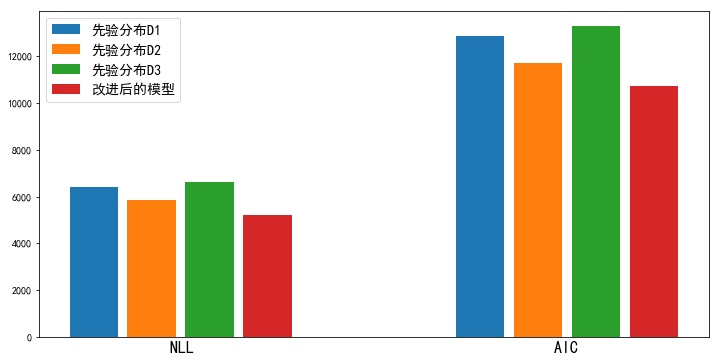

In [43]:
plt.figure(figsize=(12,6))
labels = ["先验分布D1","先验分布D2","先验分布D3","改进后的模型"]
for i in range(4):
    plt.bar(np.arange(0,4,2) + i*0.3, [NLL[i],AIC[i]], width=0.25, label=labels[i])

plt.legend(fontsize=14)
plt.xticks([])
plt.xlabel("NLL                                             AIC", fontsize=16)
plt.show()

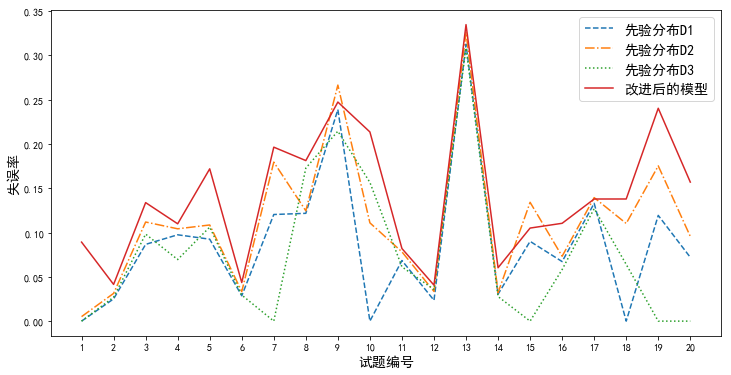

In [44]:
# plt.rcParams['font.sans-serif'] = ['SimHei'] # 步骤一（替换sans-serif字体）
# plt.rcParams['axes.unicode_minus'] = False   # 步骤二（解决坐标轴负数的负号显示问题）
plt.figure(figsize=(12,6))

x = np.arange(1,21)
plt.plot(x,ss[0], label="先验分布D1", linestyle="--")
plt.plot(x,ss[1], label="先验分布D2", linestyle="-.")
plt.plot(x,ss[2], label="先验分布D3", linestyle=":")
plt.plot(x,ss[3], label="改进后的模型")
plt.legend(fontsize=14)
plt.xticks(x)
plt.xlabel("试题编号",fontsize=14)
plt.ylabel("失误率",fontsize=14)
plt.show()

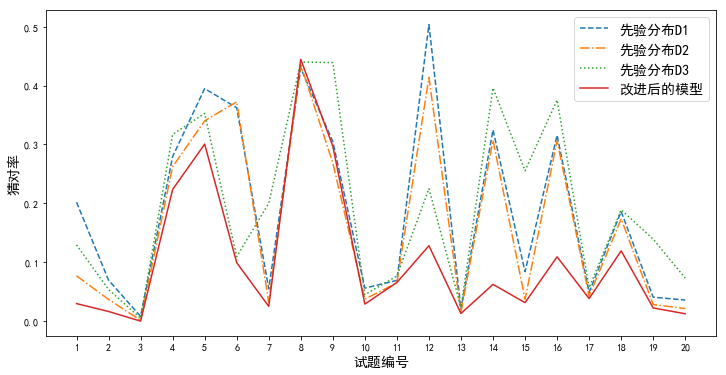

In [45]:
plt.figure(figsize=(12,6))

x = np.arange(1,21)
plt.plot(x,gs[0], label="先验分布D1", linestyle="--")
plt.plot(x,gs[1], label="先验分布D2", linestyle="-.")
plt.plot(x,gs[2], label="先验分布D3", linestyle=":")
plt.plot(x,gs[3], label="改进后的模型")
plt.legend(fontsize=14)
plt.xticks(x)
plt.xlabel("试题编号",fontsize=14)
plt.ylabel("猜对率",fontsize=14)
plt.show()